In [2]:
library(readxl)
library(stringr)
library(ggplot2)
library(MASS)
library(edfun)
library(olsrr)
library(ggthemes)
library(data.table)
library(VennDiagram)
library(pheatmap)
library(stringr)
library(readxl)
library(MASS)
library(quantreg)
library(olsrr)
library(limma)
library(BiocManager)
library(randomForest)
library(nnet)
library(energy)
library(car)
library(foreign)
library(plyr)
library(ggplot2)
library(gridExtra)
library(cowplot)
library(DescTools)
library(ggpubr)
library(ROCR)
library(gdata)
library(scales)


---------------------
Welcome to edfun version 0.2.0
Type ?edfun for the main documentation.
The github page is: https://github.com/talgalili/edfun/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/edfun/issues
Or contact: <tal.galili@gmail.com>

	To suppress this message use:  suppressPackageStartupMessages(library(edfun))
---------------------


Attaching package: ‘olsrr’

The following object is masked from ‘package:MASS’:

    cement

The following object is masked from ‘package:datasets’:

    rivers

Loading required package: grid
Loading required package: futile.logger
Loading required package: SparseM

Attaching package: ‘SparseM’

The following object is masked from ‘package:base’:

    backsolve

Bioconductor version 3.10 (BiocManager 1.30.10), ?BiocManager::install for help
Bioconductor version '3.10' is out-of-date; the current release version '3.19'
  is available with R version '4.4'; see https://bioconductor.org/install
randomForest 4.6-14


In [3]:
color_AD <- "#FF3300"
color_ND <- "blue"
color_CHC_H <- color_ND
color_CHC_M <- "#FFCC00"
color_CHC_L <- "#FF3300"
font_size <- 12
font_size_add <- 2

circle_size_1 <- 2
circle_size_2 <- 3

In [4]:
setwd("~/ownCloud/Meng/")

In [4]:
load(file="100_plus_project/Metadata/metadata_clean_update20211215.Rdata")

In [5]:
names(metadata_clean)

[1] "nbb"                                 "autopsy"                            
 [3] "sampleprepRandomization (4 batches)" "zmRandomization (10 batches)"       
 [5] "Autopsy_nr"                          "GROUP"                              
 [7] "Mass-Spec filenames (1)"             "Mass-Spec filenames (2)"            
 [9] "Diagnosis"                           "sex"                                
[11] "age"                                 "braak"                              
[13] "amyloid"                             "pmd"                                
[15] "ph"                                  "weight"                             
[17] "csf"                                 "apoe"                               
[19] "barcode"                             "Abeta"                              
[21] "APOE"

In [6]:
dim(metadata_clean)

[1] 222  21

### Remove duplicate samples from metadata

In [7]:
load(file = "100_plus_project/Metadata/all_filenames_20220901.Rdata")

In [8]:
load(file = "100_plus_project/Metadata/exclude_file_names_20220901.Rdata")

In [9]:
include_filenames <- setdiff(all_filenames, exclude_file_names)

In [10]:
length(include_filenames)

[1] 210

In [11]:
filenames_map_index <- integer(length(include_filenames))
for (i in 1:length(include_filenames)){
    filenames_map_index[i] <- ifelse(!(include_filenames[i] %in% metadata_clean[,"Mass-Spec filenames (1)"]),
                                     which(metadata_clean[,"Mass-Spec filenames (2)"] == include_filenames[i]), 
                                     which(metadata_clean[,"Mass-Spec filenames (1)"] == include_filenames[i]))
}

In [12]:
length(filenames_map_index)

[1] 210

In [13]:
names(metadata_clean)

[1] "nbb"                                 "autopsy"                            
 [3] "sampleprepRandomization (4 batches)" "zmRandomization (10 batches)"       
 [5] "Autopsy_nr"                          "GROUP"                              
 [7] "Mass-Spec filenames (1)"             "Mass-Spec filenames (2)"            
 [9] "Diagnosis"                           "sex"                                
[11] "age"                                 "braak"                              
[13] "amyloid"                             "pmd"                                
[15] "ph"                                  "weight"                             
[17] "csf"                                 "apoe"                               
[19] "barcode"                             "Abeta"                              
[21] "APOE"

In [14]:
metadata <- metadata_clean[filenames_map_index, ][c("nbb", "autopsy", 'Mass-Spec filenames (1)',
                                                    'Mass-Spec filenames (2)', "sex", "age", "weight", 
                                                    "GROUP", "pmd", "braak", "Abeta", "APOE")]
colnames(metadata) <- c("nbb", "autopsy",'Mass-Spec filenames (1)',
                        'Mass-Spec filenames (2)', "sex", "age", "weight", 
                        "GROUP", "pmd", "braak", "amyloid", "apoe")
#metadata$filenames <- names_sample

colSums(is.na(metadata))

metadata$sex[(metadata$sex=='F') | (metadata$sex=='f')] <- "F"
metadata$sex[(metadata$sex=='M') | (metadata$sex=='m')] <- "M"
metadata$braak <- as.numeric(metadata$braak)
metadata$age <- as.numeric(metadata$age)


index_AD <- which(metadata$GROUP == "AD")
index_CHC <- which(metadata$GROUP == "CHC")
index_ND <- which(metadata$GROUP == "ND")
num_AD <- length(index_AD)
num_CHC <- length(index_CHC)
num_ND <- length(index_ND)

metadata[which((metadata$GROUP=="ND") & (is.na(metadata$braak))),]$braak <- median(metadata[index_ND,]$braak, na.rm = TRUE)

metadata$fBraak <- metadata$braak
metadata[which(metadata$braak == 0), ]$fBraak <- 1

metadata$cBraak <- as.numeric(lapply(metadata$braak, function(braak){if (braak==0 | braak==1 | braak==2)
                                                                return(1)
                                                          if (braak==3 | braak==4)
                                                                return(2)
                                                          if (braak==5 | braak==6)
                                                                return(3)}))

metadata[which((metadata$GROUP=="AD") & (is.na(metadata$amyloid))),]$amyloid <- median(metadata[which((metadata$GROUP=="AD") & (!is.na(metadata$amyloid))),]$amyloid)
metadata[which((metadata$GROUP=="ND") & (is.na(metadata$amyloid))),]$amyloid <- median(metadata[which((metadata$GROUP=="ND") & (!is.na(metadata$amyloid))),]$amyloid)

metadata$O_amyloid <- sapply(metadata$amyloid, function(x){
    if(is.na(x)){
        return(NA)
    }
    if(round(x) == 0){
        return("O")
    }
    if(round(x) == 1){
        return("A")
    }
    if(round(x) == 2){
        return("B")
    }
    if(round(x) == 3){
        return("C")
    }
    
})

get_mod <- function(apoe){
    apoe_count <- as.matrix(table(apoe))
    return (rownames(apoe_count)[which.max(apoe_count)])
}

metadata[which((metadata$GROUP=="ND") & (is.na(metadata$apoe))),]$apoe <- get_mod(metadata[index_ND,]$apoe)

metadata$apoe_OR <- as.numeric(metadata$apoe)

metadata[which((metadata$apoe == 22)|(metadata$apoe == 23)|(metadata$apoe == 32)),]$apoe_OR <- 0.6
metadata[which((metadata$apoe == 24)|(metadata$apoe == 42)),]$apoe_OR <- 2.6
metadata[which(metadata$apoe == 33),]$apoe_OR <- 1
metadata[which((metadata$apoe == 34)|(metadata$apoe == 43)),]$apoe_OR <- 3.2
metadata[which(metadata$apoe == 44),]$apoe_OR <- 14.9

convert_time_2_numeric <- function(pmd){
    if (is.na(pmd))
        return (NA)
    else
        return (as.numeric(str_sub(pmd, start=1, end=2))+as.numeric(str_sub(pmd, 4))/60)
}

metadata$pmd_numeric <- apply(metadata["pmd"], 1, convert_time_2_numeric)
metadata[which(is.na(metadata$pmd_numeric)),]$pmd_numeric <- median(metadata$pmd_numeric, na.rm = TRUE)

nbb                 autopsy Mass-Spec filenames (1) 
                      0                       0                       0 
Mass-Spec filenames (2)                     sex                     age 
                    196                       0                       0 
                 weight                   GROUP                     pmd 
                      2                       0                       2 
                  braak                 amyloid                    apoe 
                      2                      19                      16

In [15]:
#metadata <- metadata_clean[filenames_map_index, ]

In [16]:
metadata$filnames <- include_filenames

In [17]:
#metadata[c("nbb", "Mass-Spec filenames (1)", "Mass-Spec filenames (2)", "filnames")]

In [18]:
metadata_CHC <- read_excel("100_plus_project/Metadata/20210930_Lancet_100plus_braindonor_overview_final.xlsx",
                           sheet=1, col_names=TRUE, skip=1, na="NA")

metadata_CHC <- metadata_CHC[1:85, ]

New names:
• `` -> `...22`
• `` -> `...23`
• `` -> `...24`
• `HIP sclerosis` -> `HIP sclerosis...48`
• `HIP sclerosis` -> `HIP sclerosis...49`
• `` -> `...165`

In [19]:
colnames(metadata_CHC)

[1] "ID"                                 
  [2] "NBB ante-mortem"                    
  [3] "NBB post-mortem"                    
  [4] "MMSE first visit >26"               
  [5] "MMSE last visit > 26"               
  [6] "MMSE last visit > 24"               
  [7] "Group"                              
  [8] "Sex"                                
  [9] "Sex numeric"                        
 [10] "BirthYear"                          
 [11] "Age at death"                       
 [12] "total_visits"                       
 [13] "Age_BSL"                            
 [14] "Age_LV"                             
 [15] "Years_before_death_BSL"             
 [16] "Years_before_death_LV"              
 [17] "CauseOfDeath"                       
 [18] "APOE"                               
 [19] "APOE logOR (Corneveaux et al. 2010)"
 [20] "PLCG2"                              
 [21] "IID"                                
 [22] "...22"                              
 [23] "...23"                              
 [24] "...24"                              
 [25] "PRS"                                
 [26] "Ganz 2018 full characterization"    
 [27] "Ganz 2018"                          
 [28] "qIHC microglia"                     
 [29] "Proteomics"                         
 [30] "5K RNAseq"                          
 [31] "PET/MRI scan"                       
 [32] "PBMCs (# samples)"                  
 [33] "iPSCs"                              
 [34] "NBB"                                
 [35] "pH CSF"                             
 [36] "PMD [m]"                            
 [37] "Brainweight [gr]"                   
 [38] "Thal Aβ stage"                      
 [39] "Amyloid phase (Hyman et al., 2012)" 
 [40] "Braak NFT stage"                    
 [41] "CERAD score"                        
 [42] "ABC (Hyman et al., 2012)"           
 [43] "AD change (Hyman et al., 2012)"     
 [44] "Thal CAA stage"                     
 [45] "Thal CAA type"                      
 [46] "Braak LB"                           
 [47] "TDP43 (Nag et al., 2015)"           
 [48] "HIP sclerosis...48"                 
 [49] "HIP sclerosis...49"                 
 [50] "Infarcts"                           
 [51] "Atherosclerosis"                    
 [52] "Atrophy"                            
 [53] "ThalGVD"                            
 [54] "ARTAG"                              
 [55] "PART (Crary et al., 2014)"          
 [56] "AGD (Ferrer et al., 2008"           
 [57] "LATE (Nelson et al. 2019)"          
 [58] "Others"                             
 [59] "Report on research drive"           
 [60] "Updated report on research drive"   
 [61] "final report with Annemieke"        
 [62] "Education_VER"                      
 [63] "Education_ISCED_N"                  
 [64] "Education_ISCED_C"                  
 [65] "MMSE_BSL"                           
 [66] "MMSE_FU"                            
 [67] "MMSE_LV"                            
 [68] "MMSE_FIRST_AVAILABLE"               
 [69] "MMSE_LAST_AVAILABLE"                
 [70] "MMSE_FIRST_VISIT_INDEX"             
 [71] "MMSE_LAST_VISIT_INDEX"              
 [72] "Forward_BSL"                        
 [73] "Forward_FU"                         
 [74] "Forward_LV"                         
 [75] "Forward_FIRST_AVAILABLE"            
 [76] "Forward_LAST_AVAILABLE"             
 [77] "Forward_FIRST_VISIT_INDEX"          
 [78] "Forward_LAST_VISIT_INDEX"           
 [79] "Backward_BSL"                       
 [80] "Backward_FU"                        
 [81] "Backward_LV"                        
 [82] "Backward_FIRST_AVAILABLE"           
 [83] "Backward_LAST_AVAILABLE"            
 [84] "Backward_FIRST_VISIT_INDEX"         
 [85] "Backward_LAST_VISIT_INDEX"          
 [86] "LetterFluency_BSL"                  
 [87] "LetterFluency_FU"                   
 [88] "LetterFluency_LV"                   
 [89] "LetterFluency_FIRST_AVAILABLE"      
 [90] "LetterFluency_LAST_AVAILABLE"       
 [91] "LetterFluency_FIRST_VISIT_INDEX"   

In [20]:
metadata_CHC[, grep("MMSE", colnames(metadata_CHC))]

MMSE first visit >26,MMSE last visit > 26,MMSE last visit > 24,MMSE_BSL,MMSE_FU,MMSE_LV,MMSE_FIRST_AVAILABLE,MMSE_LAST_AVAILABLE,MMSE_FIRST_VISIT_INDEX,MMSE_LAST_VISIT_INDEX
<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,27.00,28_30,30.00,27.00,30.00,0,2
0,0,0,14.00,NA,14.00,14.00,14.00,0,0
1,0,0,26.00,"24,2_17,12_NA_NA",NA,26.00,17.12,0,2
1,1,1,30.00,30_29_28_30,30.00,30.00,30.00,0,4
1,1,1,28.72,"27,4_29,36",29.36,28.72,29.36,0,2
0,0,0,16.00,NA,16.00,16.00,16.00,0,0
0,0,0,16.44,NA,16.44,16.44,16.44,0,0
0,0,1,25.00,22_24,24.00,25.00,24.00,0,2
1,1,1,30.00,"29_30_27_28_25,96_26,48",26.48,30.00,26.48,0,6


In [33]:
metadata_CHC_inProt <- metadata_CHC[which(metadata_CHC$"NBB post-mortem" %in% metadata$nbb), ]

In [34]:
metadata_CHC_inProt <- metadata_CHC_inProt[-which(metadata_CHC_inProt$"NBB post-mortem" == "2017-021"), ]

In [35]:
metadata_CHC_inProt

ID,NBB ante-mortem,NBB post-mortem,MMSE first visit >26,MMSE last visit > 26,MMSE last visit > 24,Group,Sex,Sex numeric,BirthYear,⋯,...165,Iba1_Frontal_Mean,Iba1_Parietal_Mean,Iba1_Temporal_Mean,CR343_Frontal_Mean,CR343_Parietal_Mean,CR343_Temporal_Mean,CD68_Frontal_Mean,CD68_Parietal_Mean,CD68_Temporal_Mean
<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,⋯,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100010,1996439,2017-023,1,1,1,escaper,f,0,1915,⋯,2017-023,1.537900,1.890950,2.3128286,6.70155000,5.97275000,5.39152727,0.7075667,0.7595000,0.8046111
100277,20180121,2018-040,0,0,0,NA,f,0,1916,⋯,2018-040,2.130000,1.513780,2.9961250,0.33086000,0.19130000,0.34591250,0.6569200,0.7047667,0.8722714
100004,2013022,2018-083,1,0,0,good decliner,f,0,1911,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
100007,2013203,2013-095,1,1,1,escaper,f,0,1912,⋯,2013-095,2.637425,1.900933,3.4423286,1.23528000,1.54906000,2.41780000,0.5050500,0.4828000,0.5439571
100080,20140470,2015-005,0,0,0,bad stable,m,1,1912,⋯,2015-005,3.319230,3.134612,5.6373286,1.10451429,0.57693333,1.80361429,0.3239167,0.3062200,0.5182625
100046,20150146,2016-026,0,0,1,escaper,f,0,1914,⋯,2016-026,2.171600,1.601225,4.2290667,0.15557250,0.20636000,0.07800333,0.2883714,0.5018200,0.3609333
100103,20150284,2016-032,0,0,1,escaper,m,1,1915,⋯,2016-032,1.062315,0.392100,1.0706000,2.31523636,1.81488571,1.46790909,0.2347286,0.2552714,0.2185667
100021,20140033,2016-094,1,1,1,escaper,f,0,1911,⋯,2016-094,1.534157,1.017260,2.5316143,1.50571667,2.38424286,2.03365714,0.4038200,0.4835833,0.4525250
100262,20160868,2017-008,0,0,0,bad stable,f,0,1916,⋯,2017-008,2.404325,1.712150,2.4442000,0.01983225,0.04196000,0.12643167,0.3279000,0.3420333,0.3457400


In [134]:
colnames(metadata_CHC_inProt)

[1] "ID"                                 
  [2] "NBB ante-mortem"                    
  [3] "NBB post-mortem"                    
  [4] "MMSE first visit >26"               
  [5] "MMSE last visit > 26"               
  [6] "MMSE last visit > 24"               
  [7] "Group"                              
  [8] "Sex"                                
  [9] "Sex numeric"                        
 [10] "BirthYear"                          
 [11] "Age at death"                       
 [12] "total_visits"                       
 [13] "Age_BSL"                            
 [14] "Age_LV"                             
 [15] "Years_before_death_BSL"             
 [16] "Years_before_death_LV"              
 [17] "CauseOfDeath"                       
 [18] "APOE"                               
 [19] "APOE logOR (Corneveaux et al. 2010)"
 [20] "PLCG2"                              
 [21] "IID"                                
 [22] "...22"                              
 [23] "...23"                              
 [24] "...24"                              
 [25] "PRS"                                
 [26] "Ganz 2018 full characterization"    
 [27] "Ganz 2018"                          
 [28] "qIHC microglia"                     
 [29] "Proteomics"                         
 [30] "5K RNAseq"                          
 [31] "PET/MRI scan"                       
 [32] "PBMCs (# samples)"                  
 [33] "iPSCs"                              
 [34] "NBB"                                
 [35] "pH CSF"                             
 [36] "PMD [m]"                            
 [37] "Brainweight [gr]"                   
 [38] "Thal Aβ stage"                      
 [39] "Amyloid phase (Hyman et al., 2012)" 
 [40] "Braak NFT stage"                    
 [41] "CERAD score"                        
 [42] "ABC (Hyman et al., 2012)"           
 [43] "AD change (Hyman et al., 2012)"     
 [44] "Thal CAA stage"                     
 [45] "Thal CAA type"                      
 [46] "Braak LB"                           
 [47] "TDP43 (Nag et al., 2015)"           
 [48] "HIP sclerosis...48"                 
 [49] "HIP sclerosis...49"                 
 [50] "Infarcts"                           
 [51] "Atherosclerosis"                    
 [52] "Atrophy"                            
 [53] "ThalGVD"                            
 [54] "ARTAG"                              
 [55] "PART (Crary et al., 2014)"          
 [56] "AGD (Ferrer et al., 2008"           
 [57] "LATE (Nelson et al. 2019)"          
 [58] "Others"                             
 [59] "Report on research drive"           
 [60] "Updated report on research drive"   
 [61] "final report with Annemieke"        
 [62] "Education_VER"                      
 [63] "Education_ISCED_N"                  
 [64] "Education_ISCED_C"                  
 [65] "MMSE_BSL"                           
 [66] "MMSE_FU"                            
 [67] "MMSE_LV"                            
 [68] "MMSE_FIRST_AVAILABLE"               
 [69] "MMSE_LAST_AVAILABLE"                
 [70] "MMSE_FIRST_VISIT_INDEX"             
 [71] "MMSE_LAST_VISIT_INDEX"              
 [72] "Forward_BSL"                        
 [73] "Forward_FU"                         
 [74] "Forward_LV"                         
 [75] "Forward_FIRST_AVAILABLE"            
 [76] "Forward_LAST_AVAILABLE"             
 [77] "Forward_FIRST_VISIT_INDEX"          
 [78] "Forward_LAST_VISIT_INDEX"           
 [79] "Backward_BSL"                       
 [80] "Backward_FU"                        
 [81] "Backward_LV"                        
 [82] "Backward_FIRST_AVAILABLE"           
 [83] "Backward_LAST_AVAILABLE"            
 [84] "Backward_FIRST_VISIT_INDEX"         
 [85] "Backward_LAST_VISIT_INDEX"          
 [86] "LetterFluency_BSL"                  
 [87] "LetterFluency_FU"                   
 [88] "LetterFluency_LV"                   
 [89] "LetterFluency_FIRST_AVAILABLE"      
 [90] "LetterFluency_LAST_AVAILABLE"       
 [91] "LetterFluency_FIRST_VISIT_INDEX"   

In [136]:
summary(metadata_CHC_inProt$Years_before_death_LV) * 12

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.960   4.740   9.540   9.259  11.730  25.920 

In [133]:
dim(metadata_CHC_inProt)
summary(metadata_CHC_inProt$MMSE_BSL)
summary(metadata_CHC_inProt$MMSE_LV)

[1]  58 174

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   9.40   23.00   25.60   24.48   27.36   30.00       1 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   9.40   22.00   25.00   23.98   26.56   30.00       9 

In [126]:
MMSE_dens_df <- data.frame(MMSE = c(metadata_CHC_inProt$MMSE_BSL, metadata_CHC_inProt$MMSE_LV),
                           When = c(rep("Baseline", nrow(metadata_CHC_inProt)), 
                                    rep("Last_visit", nrow(metadata_CHC_inProt))))

In [127]:
W <- wilcox.test(MMSE~When, data = MMSE_dens_df)$statistic
p <- wilcox.test(MMSE~When, data = MMSE_dens_df)$p.value

In [128]:
W
p

W 
1504.5

[1] 0.4942167

In [131]:
mu <- ddply(MMSE_dens_df, "When", summarise, grp.mean=median(MMSE, na.rm = T))
#head(mu)

plot <- ggplot(MMSE_dens_df, aes(x=MMSE, fill=When)) +
  geom_density(alpha = 0.45)+
  geom_vline(data=mu, aes(xintercept=grp.mean, color=When),
             linetype="dashed") +
  ylab("Density") +

  annotate("label", x = 15, y = 0.11, vjust = 1, hjust = 1, size = 5,
             label = paste("W = ", round(W, 0), "\np = ", round(p, 2)," ", sep = "")) +
    
  theme_hc() +
  scale_colour_manual(values = c("green", "red")) +
  scale_fill_manual(values = c("green", "red")) +
  theme(legend.position = "top")

In [132]:
save_plot("100_plus_plots/MMSE_shift_from_baseline_to_lastvisit_20240701.pdf", 
          plot, base_height = 6, base_width = 6)

Warning message:
“Removed 10 rows containing non-finite values (stat_density).”

In [24]:
table(metadata$GROUP)


 AD CHC  ND 
 91  58  61 

In [101]:
metadata$MMSE_LV <- sapply(metadata$nbb, function(x){
    if(!(x %in% metadata_CHC$"NBB post-mortem")){
        return(NA)
    }
    else{
        return(metadata_CHC[which(metadata_CHC$"NBB post-mortem" == x), ]$MMSE_LV)
    }
})

In [102]:
metadata$MMSE_LAST_AVAILABLE <- sapply(metadata$nbb, function(x){
    if(!(x %in% metadata_CHC$"NBB post-mortem")){
        return(NA)
    }
    else{
        return(metadata_CHC[which(metadata_CHC$"NBB post-mortem" == x), ]$MMSE_LAST_AVAILABLE)
    }
})

In [103]:
metadata$Years_before_death_LV <- sapply(metadata$nbb, function(x){
    if(!(x %in% metadata_CHC$"NBB post-mortem")){
        return(NA)
    }
    else{
        return(metadata_CHC[which(metadata_CHC$"NBB post-mortem" == x), ]$Years_before_death_LV)
    }
})

In [104]:
metadata$GROUP <- factor(metadata$GROUP, levels = c("ND", "AD", "CHC"))

In [105]:
table(metadata$GROUP)


 ND  AD CHC 
 61  91  58 

In [106]:
summary(metadata)

     nbb              autopsy          Mass-Spec filenames (1)
 Length:210         Length:210         Length:210             
 Class :character   Class :character   Class :character       
 Mode  :character   Mode  :character   Mode  :character       
                                                              
                                                              
                                                              
                                                              
 Mass-Spec filenames (2)     sex                 age            weight         
 Length:210              Length:210         Min.   : 50.00   Length:210        
 Class :character        Class :character   1st Qu.: 78.25   Class :character  
 Mode  :character        Mode  :character   Median : 89.00   Mode  :character  
                                            Mean   : 87.29                     
                                            3rd Qu.:101.00                     
                

In [107]:
save(metadata, file = "100_plus_project/Metadata/metadata_remove_duplicate_particalCHCinfo_20240401.Rdata")

### Select samples from metadata based on proteomic measurement

In [109]:
High_quality_protein_intensity_matrix <- read.table('R_workstation/100_plus_proteomic_DATA/High_quality_protein_intensity_matrix.tsv', header =TRUE,
                                                    stringsAsFactors=F, sep = "\t")
dim(High_quality_protein_intensity_matrix)

[1] 3448  191

In [110]:
names_sample <- as.array(colnames(High_quality_protein_intensity_matrix)[2:ncol(High_quality_protein_intensity_matrix)])
names_sample <- as.vector(apply(names_sample, 1, function(names){return (str_sub(names, 11))}))

filenames_map_index <- integer(length(names_sample))
for (i in 1:length(names_sample)){
    if ((names_sample[i] %in% metadata[,"Mass-Spec filenames (1)"]) | 
        (names_sample[i] %in% metadata[,"Mass-Spec filenames (2)"]))
        filenames_map_index[i] <- ifelse(length(which(metadata[,"Mass-Spec filenames (1)"] == names_sample[i]))==0,
                                     which(metadata[,"Mass-Spec filenames (2)"] == names_sample[i]), 
                                     which(metadata[,"Mass-Spec filenames (1)"] == names_sample[i]))
    else
        print("ERROR, file name not in metadata!")
}

In [111]:
length(filenames_map_index)

[1] 190

In [112]:
metadata <- metadata[filenames_map_index, ]

In [114]:
save(metadata, file = "100_plus_project/Metadata/metadata_s190_particalCHCinfo_20240401.Rdata")

In [58]:
colnames(metadata)

[1] "nbb"                   "autopsy"               "sex"                  
 [4] "age"                   "weight"                "GROUP"                
 [7] "pmd"                   "braak"                 "amyloid"              
[10] "apoe"                  "fBraak"                "cBraak"               
[13] "O_amyloid"             "apoe_OR"               "pmd_numeric"          
[16] "filnames"              "Years_before_death_LV"

In [22]:
metadata$age <- as.numeric(metadata$age)
metadata$braak <- as.numeric(metadata$braak)
metadata$weight <- as.numeric(metadata$weight)

In [23]:
sum(is.na(metadata$pmd))

[1] 2

In [24]:
convert_time_2_numeric <- function(pmd){
    if (is.na(pmd))
        return (NA)
    else
        return (as.numeric(str_sub(pmd, start=1, end=2))+as.numeric(str_sub(pmd, 4))/60)
}

metadata$pmd_numeric <- sapply(metadata$pmd, convert_time_2_numeric)
metadata[which(is.na(metadata$pmd_numeric)),]$pmd_numeric <- median(metadata$pmd_numeric, na.rm = TRUE)

In [25]:
summary(subset(metadata, GROUP != "CHC")$pmd_numeric)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.000   4.500   5.500   5.737   6.750  12.917 

In [26]:
summary(subset(metadata, GROUP == "CHC")$pmd_numeric)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.417   5.450   6.167   6.516   7.421  12.000 

In [27]:
summary(subset(metadata, GROUP == "CHC")$Years_before_death_LV) * 12

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.960   4.740   9.540   9.259  11.730  25.920 

In [28]:
mean(subset(metadata, GROUP == "CHC")$Years_before_death_LV) * 12

[1] 9.258621

In [29]:
sd(subset(metadata, GROUP == "CHC")$Years_before_death_LV) * 12

[1] 5.776153

In [30]:
summary(subset(metadata, GROUP == "AD")$age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  55.00   71.50   85.00   81.26   90.00  102.00 

In [31]:
table(metadata$braak, useNA = "ifany")


   0    1    2    3    4    5    6 <NA> 
   7   23   26   39   37   49   27    2 

In [32]:
index_ND <- which(metadata$GROUP == "ND")

metadata[which((metadata$GROUP=="ND") & (is.na(metadata$braak))),]$braak <- median(metadata[index_ND,]$braak, na.rm = TRUE)


In [33]:
table(metadata$braak, useNA = "ifany")


 0  1  2  3  4  5  6 
 7 23 28 39 37 49 27 

In [34]:
summary(subset(metadata, GROUP != "CAC")$age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  50.00   78.25   89.00   87.29  101.00  111.00 

In [38]:
summary(metadata)

     nbb              autopsy          sampleprepRandomization (4 batches)
 Length:210         Length:210         Min.   :  1.00                     
 Class :character   Class :character   1st Qu.: 56.25                     
 Mode  :character   Mode  :character   Median :109.50                     
                                       Mean   :110.59                     
                                       3rd Qu.:163.75                     
                                       Max.   :222.00                     
                                                                          
 zmRandomization (10 batches)  Autopsy_nr        GROUP   
 Min.   :  1.00               Length:210         ND :61  
 1st Qu.: 56.25               Class :character   CHC:58  
 Median :110.50               Mode  :character   AD :91  
 Mean   :111.05                                          
 3rd Qu.:166.75                                          
 Max.   :221.00                                     

In [43]:
load(file = "100_plus_project/Metadata/pathology_data_inpaper_20240717.Rdata")

In [44]:
pathology_data_inpaper$GROUP <- factor(pathology_data_inpaper$GROUP, levels = c("ND", "CEN", "AD"))

In [45]:
table(pathology_data_inpaper$GROUP)


 ND CEN  AD 
 53  49  88 

In [46]:
insert_minor <- function(major_labs, n_minor) {labs <- 
                              c( sapply( major_labs, function(x) c(x, rep("", 4) ) ) )
                              labs[1:(length(labs)-n_minor)]}

Warning message:
“Removed 6 rows containing missing values (geom_bar).”

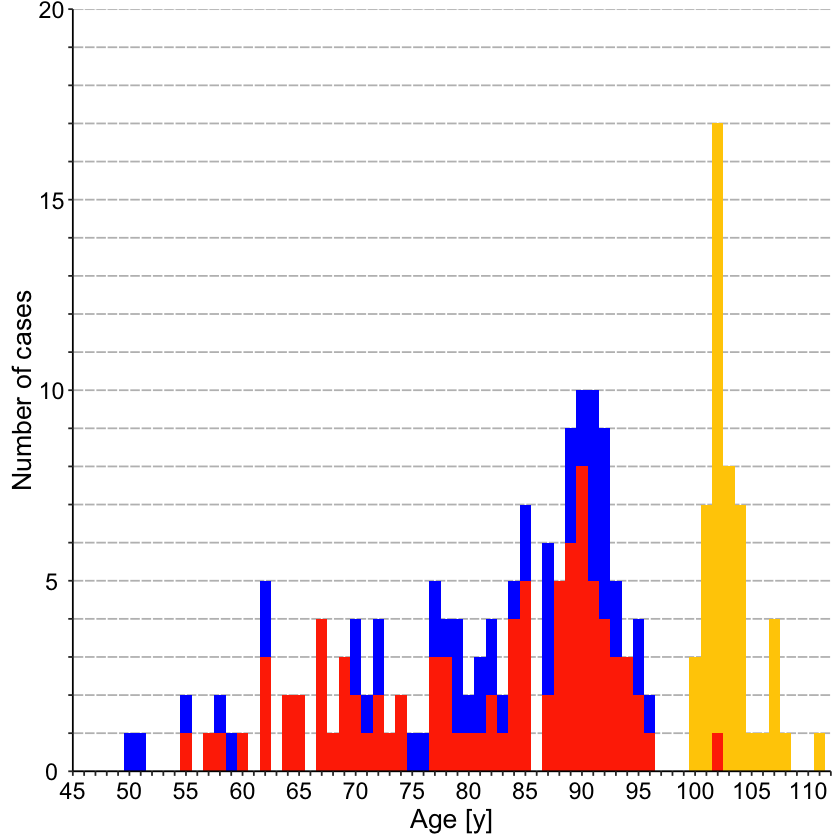

In [47]:
#jpeg(file="100_plus_plots/age_distribution_3groups.jpg", width=600*5, height=300*5, res=72*5)
p <- ggplot(pathology_data_inpaper, aes(x=age, fill=GROUP)) + 
    geom_histogram(binwidth=1, alpha=1, position="stack") +
    xlab("Age [y]") + ylab("Number of cases") +
    scale_x_continuous(limits = c(45, 112), breaks=seq(45, 115, 1), 
                       labels = insert_minor(seq(45, 115, 5), 4 ),
                       expand = c(0, 0)) +
    scale_y_continuous(limits = c(0, 20), breaks=seq(0, 20, 1), 
                       labels=insert_minor(seq(0, 20, 5), 4 ),
                       expand = c(0, 0)) +
    scale_fill_manual(name="Group", breaks = c("AD", "ND", "CEN"), 
                       values = c(color_AD, color_ND, color_CHC_M),
                       labels = c("ND",
                                  "AD", 
                                  "CHC")
                       )+
    theme(#plot.background = element_rect(),    # Background of the entire plot
          panel.background = element_rect(fill = "white"),   # Background of plotting area
          #panel.border = element_rect(),       # Border around plotting area.
                                               # fill argument should be NA
  
          #panel.grid = element_line(),         # All grid lines
          #panel.grid.major = element_line(),   # Major grid lines
          #panel.grid.minor = element_line(),   # Minor grid lines
        
          #plot.margin = ggplot2::margin(0.1, 0.5, 0.5, 0.5, "cm"),
          legend.position = "none",
  
          panel.grid.major.x = element_line(), # Vertical major grid lines
          panel.grid.major.y = element_line(size = 0.5, linetype = 'solid',
                                            color = "gray"), # Horizontal major grid lines
          #panel.grid.minor.x = element_line(), # Vertical minor grid lines
          #panel.grid.minor.y = element_line(size = 0.5, linetype = 'solid',
          #                      color = "gray"),  # Vertical major grid lines
        
          plot.title = element_text(face = "bold", colour = "black", 
                                    size = font_size+font_size_add*2#, hjust = -0.08
                                   ),
        
          axis.title.x = element_text(color = "black", size = font_size+font_size_add * 2,
                                      vjust = 0.5, hjust = 0.5),
          axis.title.y = element_text(color = "black", size = font_size+font_size_add * 2,
                                      vjust = 0.5, hjust = 0.5),

          axis.text.x = element_text(size = font_size+font_size_add, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = font_size+font_size_add, color = "black",
                                     vjust = 0.5, hjust = 0.5),
          
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "black")
         )
p

#dev.off()

In [48]:
save_plot("100_plus_plots/age_distribution_3groups_in190samples_20231110.pdf", 
          p, base_height = 4, base_width = 12)

Warning message:
“Removed 6 rows containing missing values (geom_bar).”

In [84]:
colnames(pathology_data_inpaper)

[1] "nbb"                                                         
 [2] "GROUP"                                                       
 [3] "sex"                                                         
 [4] "age"                                                         
 [5] "pmd"                                                         
 [6] "ph"                                                          
 [7] "Brain weight [g]"                                            
 [8] "APOE"                                                        
 [9] "CDR"                                                         
[10] "Reisberg"                                                    
[11] "Cause of death"                                              
[12] "chronic diseases"                                            
[13] "ABC (Hyman 2012)"                                            
[14] "Atrophy (0=none/1=slight/2=moderate/3=severe)"               
[15] "Atherosclerosis (0=none/1=slight/2=moderate/3=severe)"       
[16] "Amyloid (A from ABC score Hyman 2012)"                       
[17] "Braak&Braak stage\r\nNFTs"                                   
[18] "Neuritic plaques (CERAD)"                                    
[19] "Lewy bodies (Braak staging)"                                 
[20] "Hip sclerosis (absent=0; present=1)"                         
[21] "Infarcts (absent=0; present=1)"                              
[22] "CAA\r\n (Thal Stage)"                                        
[23] "TDP-43 Centenarians (Nelson et al., 2023)"                   
[24] "TDP-43 positivity in the amygdala (0=none; 1=little; 2=many)"

In [86]:
table(pathology_data_inpaper$'Amyloid (A from ABC score Hyman 2012)', pathology_data_inpaper$GROUP)

   
    ND CEN AD
  0 17   3  0
  1 16  18  0
  2 16  16  7
  3  2  12 81

In [70]:
ND_count <- table(subset(pathology_data_inpaper, GROUP == "ND")$age) %>% as.data.frame()
ND_count$GROUP <- "ND"
AD_count <- table(subset(pathology_data_inpaper, GROUP == "AD")$age) %>% as.data.frame()
AD_count$GROUP <- "AD"
CEN_count <- table(subset(pathology_data_inpaper, GROUP == "CEN")$age) %>% as.data.frame()
CEN_count$GROUP <- "CEN"

In [71]:
plot_df <- rbind(ND_count, AD_count, CEN_count)

In [72]:
colnames(plot_df) <- c("age", "Count", "GROUP")

In [73]:
plot_df$GROUP <- factor(plot_df$GROUP, levels = c("ND", "CEN", "AD"))

In [77]:
plot_df$age <- as.numeric(as.character(plot_df$age))

In [82]:
sum(plot_df$Count)

[1] 190

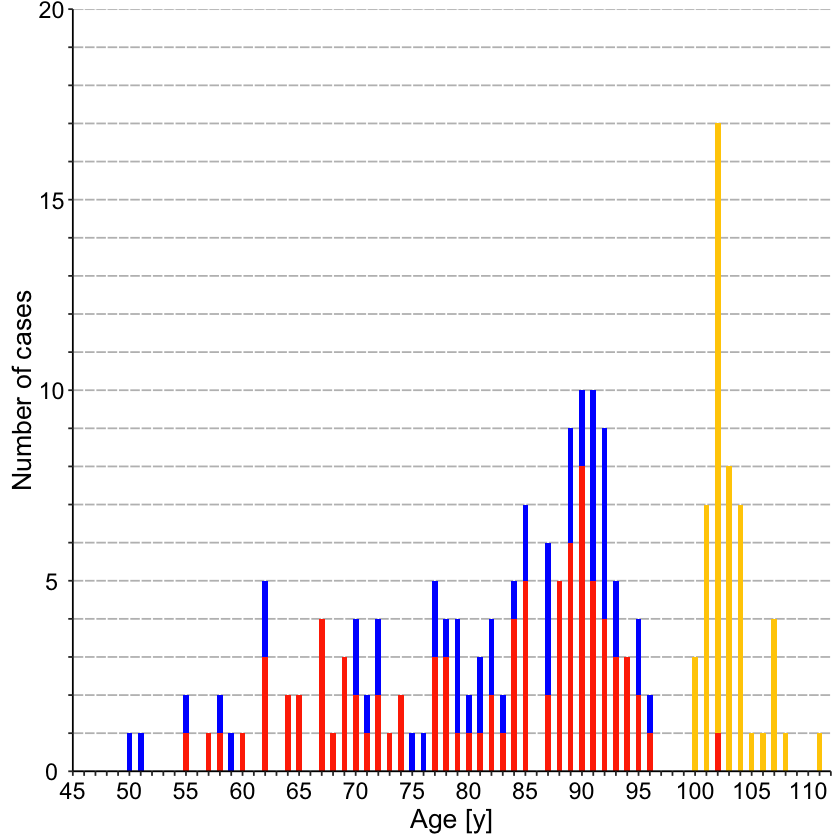

In [80]:
#jpeg(file="100_plus_plots/age_distribution_3groups.jpg", width=600*5, height=300*5, res=72*5)
p <- ggplot(plot_df, aes(x=age, y=Count, fill=GROUP)) + 
    geom_bar(stat = "identity", width=0.5) +
    xlab("Age [y]") + ylab("Number of cases") +
    scale_x_continuous(limits = c(45, 112), breaks=seq(45, 115, 1), 
                       labels = insert_minor(seq(45, 115, 5), 4 ),
                       expand = c(0, 0)) +
    scale_y_continuous(limits = c(0, 20), breaks=seq(0, 20, 1), 
                       labels=insert_minor(seq(0, 20, 5), 4 ),
                       expand = c(0, 0)) +
    scale_fill_manual(name="Group", breaks = c("AD", "ND", "CEN"), 
                       values = c(color_AD, color_ND, color_CHC_M),
                       labels = c("ND",
                                  "AD", 
                                  "CHC")
                       )+
    theme(#plot.background = element_rect(),    # Background of the entire plot
          panel.background = element_rect(fill = "white"),   # Background of plotting area
          #panel.border = element_rect(),       # Border around plotting area.
                                               # fill argument should be NA
  
          #panel.grid = element_line(),         # All grid lines
          #panel.grid.major = element_line(),   # Major grid lines
          #panel.grid.minor = element_line(),   # Minor grid lines
        
          #plot.margin = ggplot2::margin(0.1, 0.5, 0.5, 0.5, "cm"),
          legend.position = "none",
  
          panel.grid.major.x = element_line(), # Vertical major grid lines
          panel.grid.major.y = element_line(size = 0.5, linetype = 'solid',
                                            color = "gray"), # Horizontal major grid lines
          #panel.grid.minor.x = element_line(), # Vertical minor grid lines
          #panel.grid.minor.y = element_line(size = 0.5, linetype = 'solid',
          #                      color = "gray"),  # Vertical major grid lines
        
          plot.title = element_text(face = "bold", colour = "black", 
                                    size = font_size+font_size_add*2#, hjust = -0.08
                                   ),
        
          axis.title.x = element_text(color = "black", size = font_size+font_size_add * 2,
                                      vjust = 0.5, hjust = 0.5),
          axis.title.y = element_text(color = "black", size = font_size+font_size_add * 2,
                                      vjust = 0.5, hjust = 0.5),

          axis.text.x = element_text(size = font_size+font_size_add, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = font_size+font_size_add, color = "black",
                                     vjust = 0.5, hjust = 0.5),
          
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "black")
         )
p

#dev.off()

In [81]:
save_plot("100_plus_plots/age_distribution_3groups_in190samples_20231110.pdf", 
          p, base_height = 4, base_width = 12)

In [14]:
table(metadata_unique$braak,  useNA = "ifany")


 0  1  2  3  4  5  6 
 7 23 28 39 37 49 27 

In [18]:
jpeg(file="100_plus_plots/Braak_distribution_3groups.jpg", width=400*5, height=300*5, res=72*5)
p <- ggplot(metadata_unique, aes(x=braak, fill=GROUP)) + 
    geom_bar(aes(x = braak, y = ..count..), width =0.7, alpha=0.7, position="stack") +
    xlab("Braak stage") + ylab("Number of cases") +
    scale_x_continuous(breaks=seq(0, 6, 1), labels=c("0", "I", "II", "III", "IV", "V", "VI")) +
    scale_fill_manual(name="Group", breaks = c("ND", "AD", "CHC"), 
                       values = c(color_ND, color_AD, color_CHC_M),
                       labels = c("ND",
                                  "AD", 
                                  "CHC")
                       )+
    theme(#plot.background = element_rect(),    # Background of the entire plot
          panel.background = element_rect(fill = "white"),   # Background of plotting area
          #panel.border = element_rect(),       # Border around plotting area.
                                               # fill argument should be NA
  
          #panel.grid = element_line(),         # All grid lines
          #panel.grid.major = element_line(),   # Major grid lines
          #panel.grid.minor = element_line(),   # Minor grid lines
          legend.position = "none",
          #plot.margin = ggplot2::margin(0.1, 0.5, 0.5, 0.5, "cm"),
  
          panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
                                color = "gray"), # Vertical major grid lines
          panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
                                color = "gray"), # Horizontal major grid lines
          panel.grid.minor.x = element_line(), # Vertical minor grid lines
          panel.grid.minor.y = element_line(),  # Vertical major grid lines
        
          plot.title = element_text(face = "bold", colour = "black", 
                                    size = font_size+font_size_add*2#, hjust = -0.08
                                   ),
        
          axis.title.x = element_text(color = "black", size = font_size+font_size_add,
                                      vjust = 0.5, hjust = 0.5),
          axis.title.y = element_text(color = "black", size = font_size+font_size_add,
                                      vjust = 0.5, hjust = 0.5),

          
          axis.text.x = element_text(size = font_size, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = font_size, color = "black",
                                     vjust = 0.5, hjust = 0.5),
          
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "gray")
         )
p
dev.off()

pdf 
  2